# IKZF1
[common variable immunodeficiency-13 (CVID13)](https://omim.org/entry/616873) is caused by heterozygous mutation in the IKZF1 gene. CVID13 is an autosomal dominant primary immunodeficiency disorder characterized by recurrent bacterial infections, mainly affecting the respiratory tract, and associated with hypogammaglobulinemia and decreased numbers of B cells. The age at onset of clinical features can range from infancy to adulthood.
Many published IKZF1 vairants are thought to be loss of function ([PMID: 31057532](https://pubmed.ncbi.nlm.nih.gov/31057532/)). Heterozygous mutations affecting amino acid N159 located in the DNA-binding domain of IKZF1 are thought to act in a dominant-negative fashion and were reported to be associated with early-onset and severe manifestations often including
Pneumocystis jirovecii pneumonia ([PMID:](29889099)https://pubmed.ncbi.nlm.nih.gov/29889099/).
Here, we test a cohort of individuals with pathogenic IKZF1 variants.

In [1]:
import gpsea
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.3.1.dev0


# TODO
Here phenopackets are loaded from a local directory. Change the code to use the phenopacket-store loader after the next release.

In [2]:
from pyphetools.visualization import PhenopacketIngestor
ikzf1_dir = "/Users/robin/GIT/phenopacket-store/notebooks/IKZF1/phenopackets"
import os 
if not os.path.isdir(ikzf1_dir):
     raise FileNotFoundError(f"Could not find {ikzf1_dir}.")                
ingestor = PhenopacketIngestor(indir=ikzf1_dir)
phenopackets = ingestor.get_phenopacket_list()
cohort_name = "IKZF1"

print(f"Imported {len(phenopackets)} phenopackets from cohort {cohort_name}")

[pyphetools] Ingested 82 GA4GH phenopackets.
Imported 82 phenopackets from cohort IKZF1


In [3]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(phenopackets=phenopackets,cohort_creator=cohort_creator,)

Patients Created: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]


In [4]:
validation.summarize()  

Validated under none policy
No errors or warnings were found


# IKZF1
We load the MANE IKZF1 transcript and the corresponding protein. The tables then show a summary of the cohort with the most common HPO annotations and variants.

In [5]:
IKZF1_MANE_transcript = 'NM_006060.6'
IKZF1_protein_id = 'NP_006051.1' # DNA-binding protein Ikaros isoform 1
from gpsea.view import CohortViewable
cv = CohortViewable(hpo=hpo)
report = cv.process(cohort=cohort, transcript_id=IKZF1_MANE_transcript)
display(HTML(report))

HPO Term,ID,Seen in n individuals
B lymphocytopenia,HP:0010976,61
Decreased circulating IgA concentration,HP:0002720,50
Decreased circulating total IgM,HP:0002850,49
Decreased circulating IgG concentration,HP:0004315,46
Decreased CD4:CD8 ratio,HP:0033222,29
Decreased proportion of memory B cells,HP:0030374,22
Recurrent infections,HP:0002719,17
Decreased proportion of CD4-positive T cells,HP:0032218,16
Recurrent pneumonia,HP:0006532,14
Pneumocystis jirovecii pneumonia,HP:0020102,14


In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(IKZF1_MANE_transcript)
protein_meta = pms.annotate(IKZF1_protein_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_18465/926109318.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


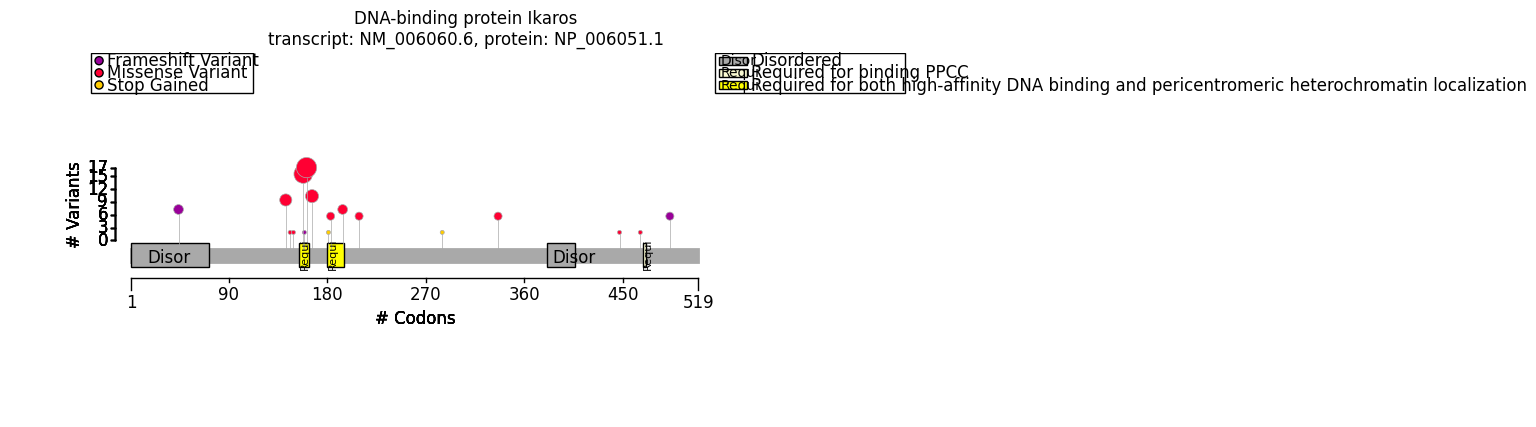

In [7]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()
#fig.savefig('docs/img/tutorial/ikzf1_protein_diagram.png')  #

In [8]:
from gpsea.analysis.predicate.genotype import ModeOfInheritancePredicate, VariantPredicates
vp = VariantPredicates.variant_key("7_50382594_50382594_A_G")  # p.Asn159Ser	

gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(
    variant_predicate=vp,
)

In [9]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()

In [10]:
from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [11]:
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
display(HTML(mtc_report))

Code,Reason,Count
TODO,Skipping general term,51
TODO,Skipping term because all genotypes have same HPO observed proportions,41
TODO,Skipping term with maximum frequency that was less than threshold 0.2,15
TODO,Skipping term with only 3 observations (not powered for 2x2),14
TODO,Skipping term because one genotype had zero observations,12
TODO,Skipping term with only 6 observations (not powered for 2x2),10
TODO,Skipping term with only 5 observations (not powered for 2x2),5
TODO,Skipping term with only 2 observations (not powered for 2x2),5
TODO,Skipping term with only 4 observations (not powered for 2x2),4
TODO,Skipping term because no genotype has more than one observed HPO count,1


# Fisher Exact Test
Individuals with 	c.476A>G;p.Asn159Ser (HET) is compared to those with other IKZF1 variants (HOM_REF - with respect to p.Asn159Ser). Individuals with p.Asn159Ser have a statistically significantly higher frequency of Pneumocystis jirovecii pneumonia , Recurrent pneumonia, and T-cell acute lymphoblastic leukemia.

In [12]:
from gpsea.analysis.predicate import PatientCategories
summary_df = result.summarize(hpo, PatientCategories.YES)
summary_df.head(45)

Which genotype group does the patient fit in       HOM_REF            HET  \
                                                     Count Percent  Count   
Pneumocystis jirovecii pneumonia [HP:0020102]         1/15      7%  13/13   
Recurrent pneumonia [HP:0006532]                      7/39     18%    7/9   
T-cell acute lymphoblastic leukemias [HP:0006727]     0/69      0%   3/13   
Recurrent otitis media [HP:0000403]                   7/48     15%    3/6   
Decreased circulating total IgM [HP:0002850]         40/56     71%    9/9   
Lung abscess [HP:0025044]                             0/14      0%    2/7   
Recurrent sinusitis [HP:0011108]                      5/50     10%    1/1   
Reduced natural killer cell count [HP:0040218]        6/20     30%    2/2   
Decreased CD4:CD8 ratio [HP:0033222]                 28/59     47%    1/7   
Chronic diarrhea [HP:0002028]                         6/49     12%    1/1   
Neutropenia [HP:0001875]                               4/9     44%    6/7   
Decreased circulating IgG concentration [HP:000...   38/51     75%    8/8   
Decreased circulating IgA concentration [HP:000...   41/54     76%    9/9   
B lymphocytopenia [HP:0010976]                       48/58     83%  13/13   
Chronic oral candidiasis [HP:0009098]                  0/7      0%    3/7   
Thrombocytopenia [HP:0001873]                        11/13     85%    0/1   
Increased proportion of CD4-positive T cells [H...    6/28     21%   4/10   
Splenomegaly [HP:0001744]                             5/12     42%    1/1   
Recurrent lower respiratory tract infections [H...    8/10     80%    7/7   
Recurrent upper respiratory tract infections [H...    8/13     62%    1/1   
Recurrent respiratory infections [HP:0002205]        23/25     92%    9/9   
Decreased proportion of CD4-positive T cells [H...   12/33     36%   4/10   
Decreased proportion of transitional B cells [H...     2/9     22%    1/4   
Decreased proportion of plasmablasts [HP:0032129]      5/8     62%    1/1   
Sinusitis [HP:0000246]                                 5/6     83%    1/1   
Abnormal paranasal sinus morphology [HP:0000245]       5/6     83%    1/1   
Abnormal facial skeleton morphology [HP:0011821]       5/6     83%    1/1   
Abnormal axial skeleton morphology [HP:0009121]        5/6     83%    1/1   
Premature birth [HP:0001622]                          3/12     25%    0/1   
Pancytopenia [HP:0001876]                             3/13     23%    0/1   
Abnormal B cell count [HP:0010975]                   57/57    100%  13/13   
Abnormal lymphocyte count [HP:0040088]               60/60    100%  13/13   
Abnormal leukocyte count [HP:0011893]                60/60    100%  13/13   
Abnormal leukocyte morphology [HP:0001881]           62/62    100%  13/13   
Abnormal cellular immune system morphology [HP:...   62/62    100%  13/13   
Abnormal immune system morphology [HP:0032251]       62/62    100%  13/13   
Abnormality of the immune system [HP:0002715]        66/66    100%  13/13   
Phenotypic abnormality [HP:0000118]                  67/67    100%  13/13   
All [HP:0000001]                                     67/67    100%  13/13   
Abnormality of blood and blood-forming tissues ...   65/65    100%  13/13   
Abnormal lymphocyte morphology [HP:0004332]          60/60    100%  13/13   
Abnormal B cell morphology [HP:0002846]              57/57    100%  13/13   
Lymphopenia [HP:0001888]                             48/48    100%  13/13   
Abnormal circulating IgG concentration [HP:0410...   38/38    100%    8/8   
Abnormal circulating immunoglobulin concentrati...   56/56    100%  13/13   

Which genotype group does the patient fit in                                   \
                                                   Percent Corrected p values   
Pneumocystis jirovecii pneumonia [HP:0020102]         100%           0.000022   
Recurrent pneumonia [HP:0006532]                       78%           0.018151   
T-cell acute lymphoblastic leukemias [HP:0006727]      2